In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
pd.set_option('display.max_columns', None)
import math
from scipy.integrate import odeint
import matplotlib.animation
from IPython.display import Image, HTML, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
matplotlib.rcParams['figure.figsize'] = 20, 10

In [3]:
def prepare_plot(left_columns, left_colors, right_columns, right_colors, 
                        name, index_range, left_range, right_range, legend_loc='lower right'):
    fig, ax = plt.subplots()
    fig.set_size_inches(w=10, h=5)

    left_lines = [ax.plot(index_range, left_range, color=c, label=l)[0] for l, c in zip(left_columns, left_colors)]

    ax_right = ax.twinx()
    right_lines = [ax_right.plot(index_range, right_range, color=c, label=l)[0] for l, c in zip(right_columns, right_colors)]

    lines = left_lines + right_lines
    columns = left_columns + right_columns
    ax.legend(lines, columns, loc=legend_loc)

    plt.subplots_adjust(left=0.05, right=0.93, bottom=0.05, top=0.90)
    # todo try fig.tight_layout()

    plt.title(name, fontsize=25)

    return fig, lines, columns


def save_animation(data, left_columns, left_colors, right_columns, right_colors, name, 
                   left_range, right_range, legend_loc='upper right'):

    fig, lines, columns = prepare_plot(left_columns, left_colors, right_columns, right_colors, 
                        name, [data.index.min(), data.index.max()], left_range, right_range, legend_loc)

    [line.set_data(data.index, data[column]) for (line, column) in zip(lines, columns)]
    plt.savefig('img-generated/' + name + '.png', dpi=100)

    animate = lambda i: [line.set_data(data.index[:i], data[column].iloc[:i]) 
                         for (line, column) in zip(lines, columns)]

    frames = np.linspace(0, data.shape[0] - 1, 125, dtype=np.int)
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=40)

    ani.save('img-generated/' + name + '.gif', writer="imagemagick", dpi=100, fps=25)


def parameter_animation(parameter_space, left_columns, left_colors, right_columns, right_colors, 
                        name, index_range, left_range, right_range, legend_loc='lower right'):

    fig, lines, columns = prepare_plot(left_columns, left_colors, right_columns, right_colors, 
                        name, index_range, left_range, right_range, legend_loc)
    
    def animate(parameters):
        data = pid(**parameters)
        return [line.set_data(data.index, data[column]) for (line, column) in zip(lines, columns)]

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=parameter_space.to_dict('records'), interval=40)

    ani.save('img-generated/' + name + '.gif', writer="imagemagick", dpi=100, fps=25)

mash tun dimensions

In [4]:
radius = 0.15
height = 0.75

In [5]:
volume = math.pi * math.pow(radius, 2) * height
volume

0.053014376029327764

In [6]:
surface = 2 * math.pi * radius * height + 2 * math.pi * math.pow(radius, 2)
surface

0.8482300164692441

In [7]:
# specific heat https://en.wikipedia.org/wiki/Heat_capacity#Measurement
# in J/(kg⋅K)
Cp = 3000
heat_capacity = Cp * volume * 1000

# air convection, in W/(m^2*K)
heat_transfer_coefficient = 30

In [8]:
# ambient heat loss in Watts
heat_transfer_coefficient * surface * (75 - 25)

1272.345024703866

In [9]:
# time to heat to target temperature (seconds)
heat_capacity * (75 - 50) / 3000

1325.3594007331942

In [10]:
# https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling
def temperature_derivative(temperature, time, power, external_temperature, 
                  heat_capacity, heat_transfer_coefficient, surface):
    return (power - heat_transfer_coefficient * surface * (temperature - external_temperature)) / heat_capacity

### heat cool

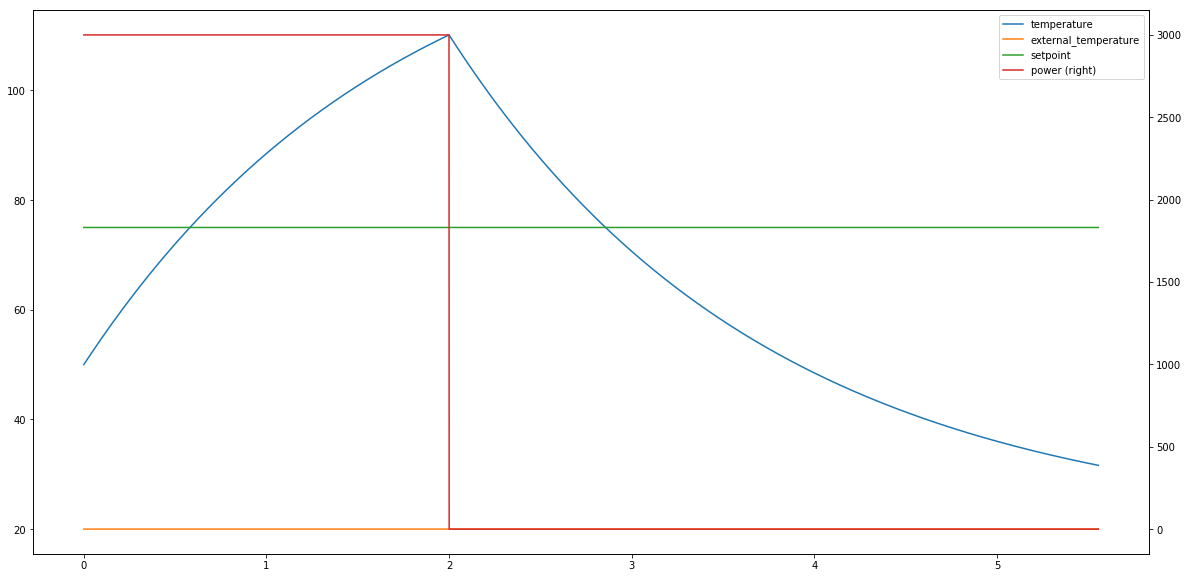

In [11]:
time = np.arange(0, 20000, 1, dtype=np.float64)
power = np.full_like(time, 3000)
power[7200:] = 0
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 75)

for i in range(len(time) - 1):
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.plot(secondary_y=('power'));

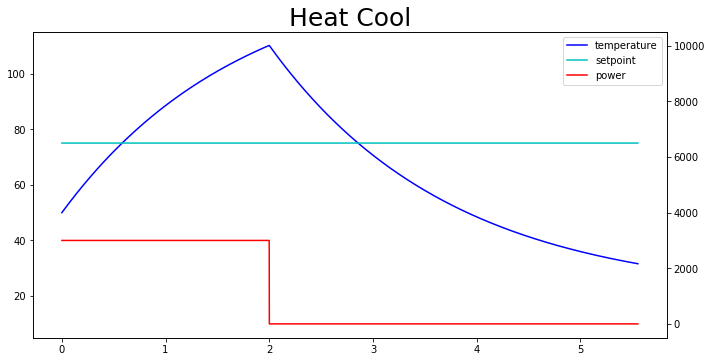

In [12]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c', 'g']
left_range = [10, 110]

right_columns = ['power']
right_colors = ['r']
right_range = [0, 10000]

save_animation(data, left_columns, left_colors, right_columns, right_colors, 'Heat Cool', left_range, right_range)

### relay controller

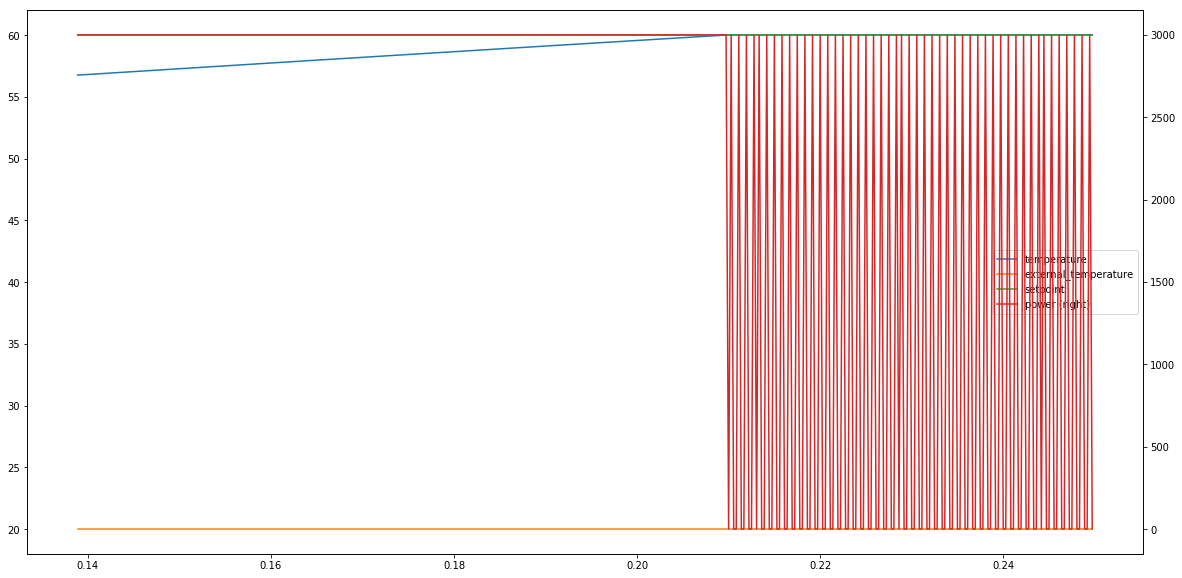

In [13]:
time = np.arange(0, 1500, 1, dtype=np.float64)
power = np.full_like(time, 3000)
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 60)

for i in range(len(time) - 1):
    if (temperature[i] < setpoint[i]):
        power[i+1] = 3000
    else:
        power[i+1] = 0
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.iloc[500:900].plot(secondary_y=('power'));

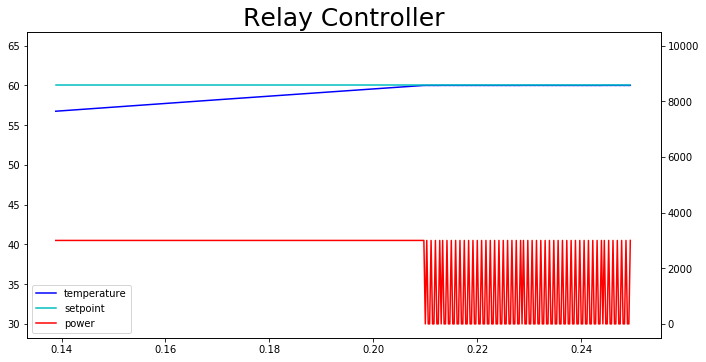

In [14]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c']
left_range = [30, 65]

right_columns = ['power']
right_colors = ['r']

save_animation(data.iloc[500:900], left_columns, left_colors, right_columns, right_colors, 
               'Relay Controller', left_range, right_range, 'lower left')

### relay delay

In [15]:
time = np.arange(0, 1500, 1, dtype=np.float64)
power = np.full_like(time, 3000)
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 60)

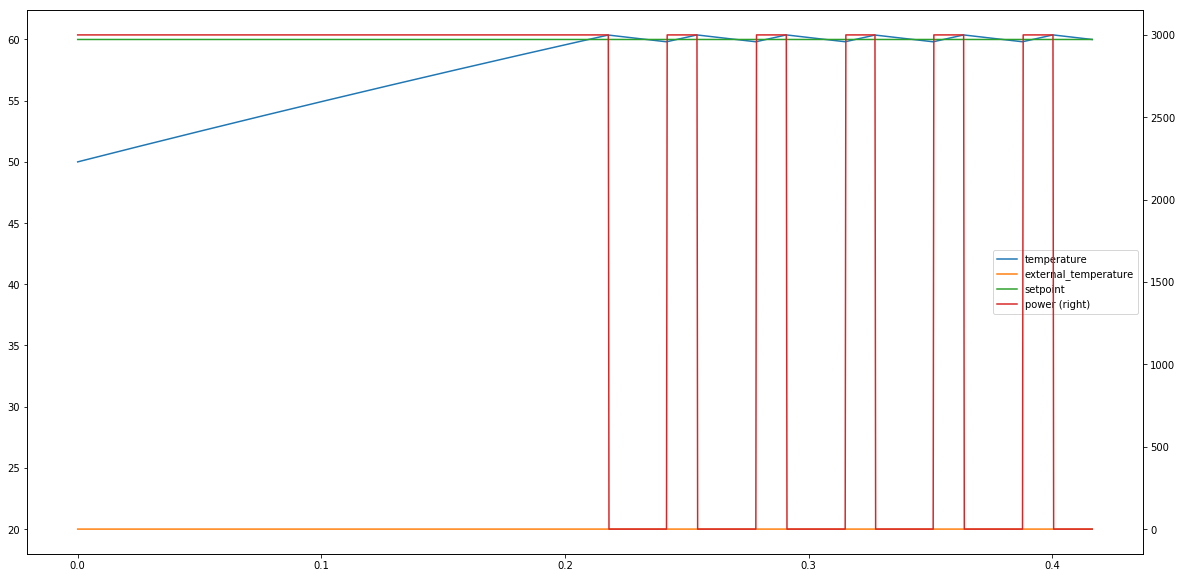

In [16]:
for i in range(len(time) - 1):
    if i + 30 < len(time):
        if temperature[i] < setpoint[i]:
            power[i + 30] = 3000
        else:
            power[i + 30] = 0
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.plot(secondary_y=('power'));

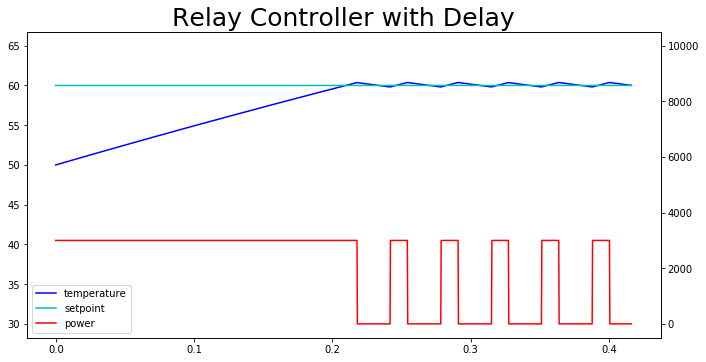

In [17]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c']

right_columns = ['power']
right_colors = ['r']

save_animation(data, left_columns, left_colors, right_columns, right_colors, 
               'Relay Controller with Delay', left_range, right_range, 'lower left')

### high power slow relay

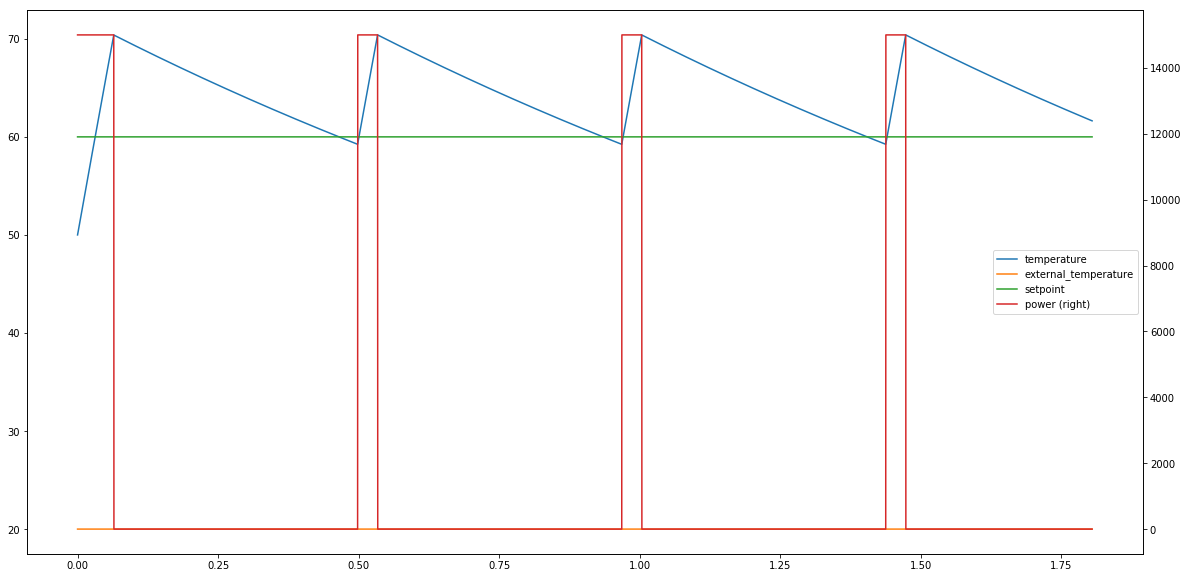

In [18]:
time = np.arange(0, 6500, 1, dtype=np.float64)
max_power = 15000
power = np.full_like(time, max_power)
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 60)
delay = 120

for i in range(len(time) - 1):
    if temperature[i] < setpoint[i]:
        next_power = max_power
    else:
        next_power = 0
    if i + delay < len(time):
        power[i + delay] = next_power
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.plot(secondary_y=('power'));

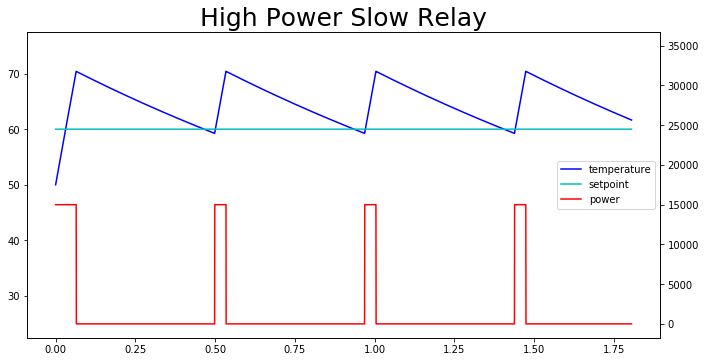

In [19]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c']
left_range = [25, 75]

right_columns = ['power']
right_colors = ['r']
right_range = [0, 35000]

save_animation(data, left_columns, left_colors, right_columns, right_colors, 
               'High Power Slow Relay', left_range, right_range, 'center right')

### meet P from PID

In [20]:
def proportional_controller(proportional):
    time = np.arange(0, 6000, 1, dtype=np.float64)
    max_power = 15000
    power = np.full_like(time, 3000)
    external_temperature = np.full_like(time, 20)
    temperature = np.full_like(time, np.nan)
    temperature[0] = 50
    setpoint = np.full_like(time, 60)
    delay = 120
    error = np.zeros_like(time)

    for i in range(len(time) - 1):
        error[i] = temperature[i] - setpoint[i]
        next_power = - proportional * error[i]
        if i + delay < len(time):
            power[i + delay] = next_power
        temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                                  args=(power[i+1], external_temperature[i], heat_capacity, 
                                        heat_transfer_coefficient, surface),
                                 )[-1]

    data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                                   'external_temperature': external_temperature,
                                   'setpoint': setpoint,
                                   'power': power,
                                   'error': error
                                  })
    data.plot(secondary_y=('power'))
    plt.show()
    return data

display(interactive(proportional_controller, proportional=widgets.FloatSlider(min=1, max=2500, value=1000)))

interactive(children=(FloatSlider(value=1000.0, description='proportional', max=2500.0, min=1.0), Output()), _…

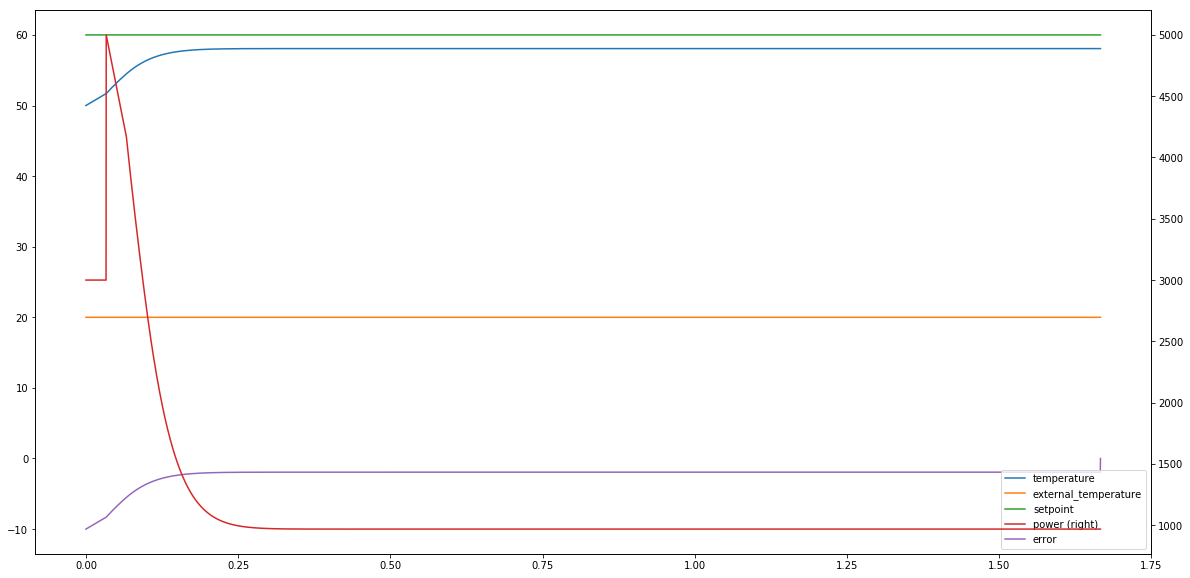

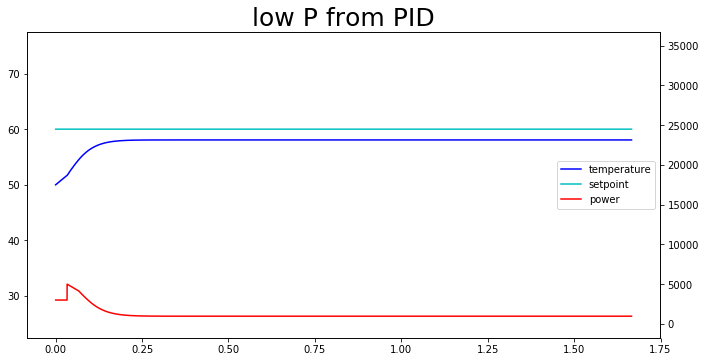

In [21]:
save_animation(proportional_controller(500), left_columns, left_colors, right_columns, right_colors, 
               'low P from PID', left_range, right_range, 'center right')

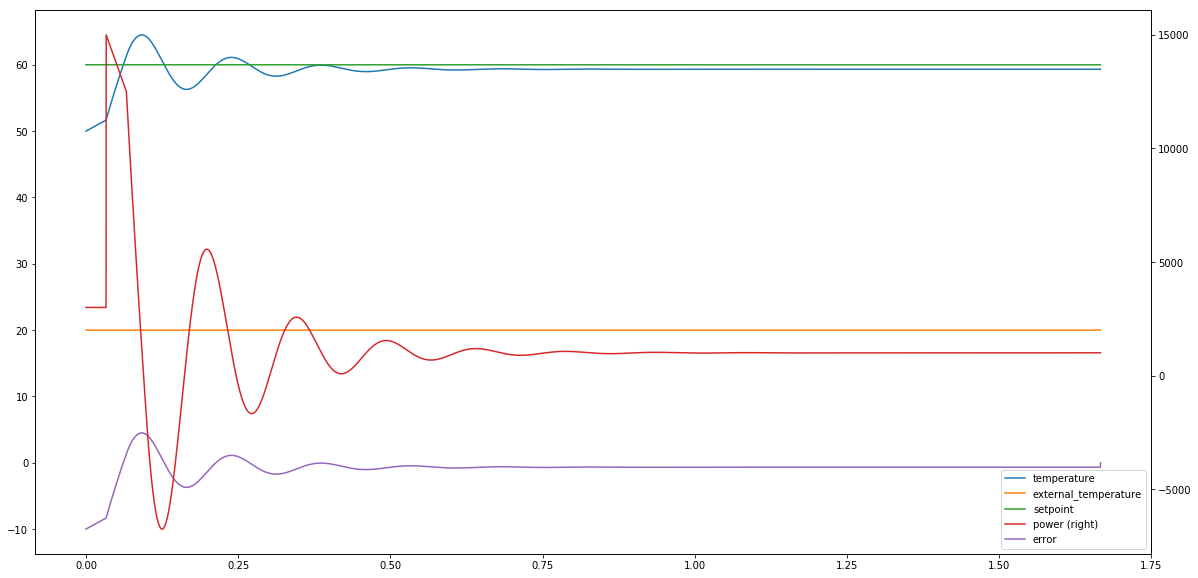

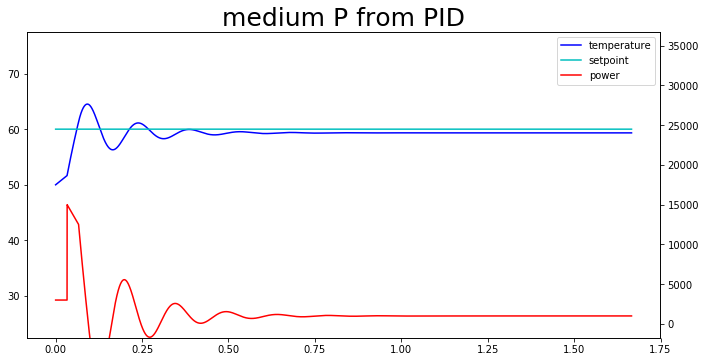

In [22]:
save_animation(proportional_controller(1500), left_columns, left_colors, right_columns, right_colors, 
               'medium P from PID', left_range, right_range, 'upper right')

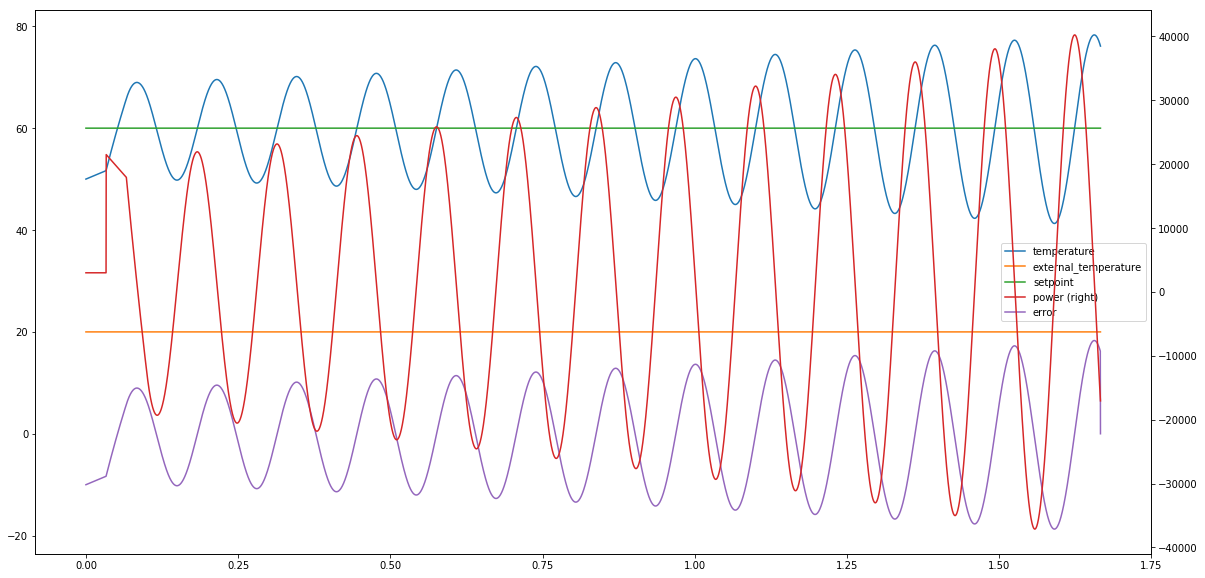

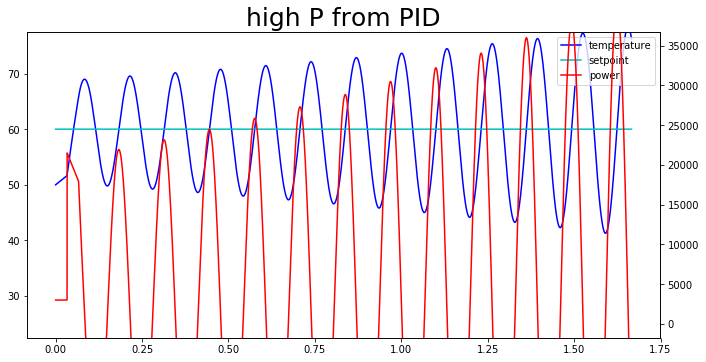

In [23]:
save_animation(proportional_controller(2150), left_columns, left_colors, right_columns, right_colors, 
               'high P from PID', left_range, right_range, 'upper right')

In [24]:
def proportional_limited(proportional):
    time = np.arange(0, 12000, 1, dtype=np.float64)
    max_power = 15000
    power = np.full_like(time, 3000)
    external_temperature = np.full_like(time, 20)
    temperature = np.full_like(time, np.nan)
    temperature[0] = 50
    setpoint = np.full_like(time, 60)
    delay = 120
    error = np.zeros_like(time)

    for i in range(len(time) - 1):
        error[i] = temperature[i] - setpoint[i]
        next_power = - proportional * error[i]
        if next_power > max_power:
            next_power = max_power
        elif next_power < 0:
            next_power = 0
        if i + delay < len(time):
            power[i + delay] = next_power
        temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                                  args=(power[i+1], external_temperature[i], heat_capacity, 
                                        heat_transfer_coefficient, surface),
                                 )[-1]

    data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                                   'external_temperature': external_temperature,
                                   'setpoint': setpoint,
                                   'power': power,
                                   'error': error
                                  })
    data.plot(secondary_y=('power'))
    plt.show()
    return data

display(interactive(proportional_limited, proportional=widgets.FloatSlider(min=1, max=10000, value=1800)))

interactive(children=(FloatSlider(value=1800.0, description='proportional', max=10000.0, min=1.0), Output()), …

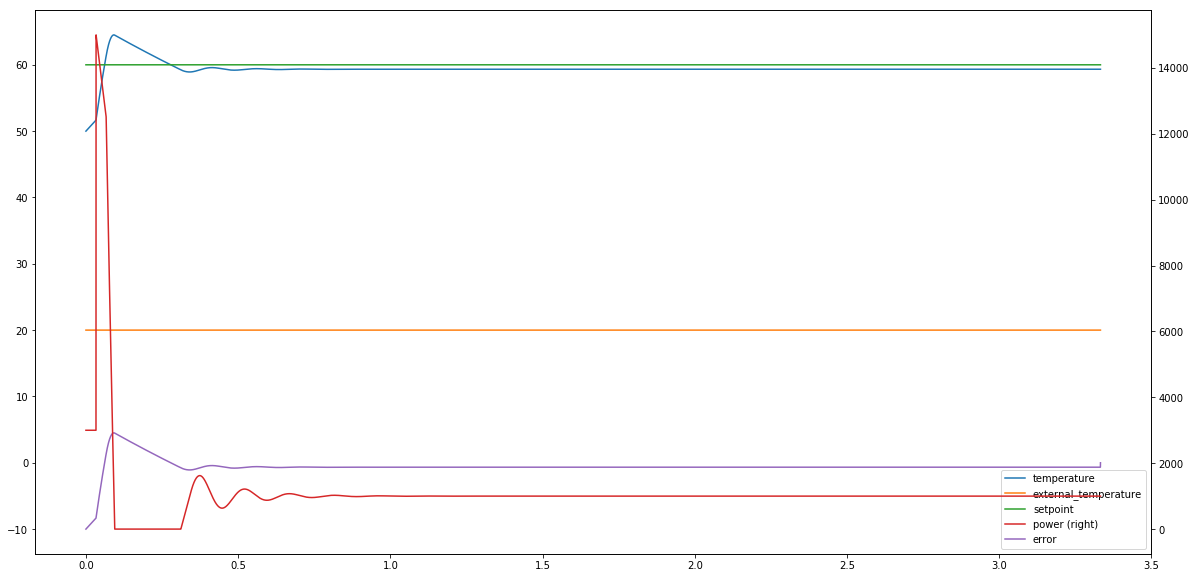

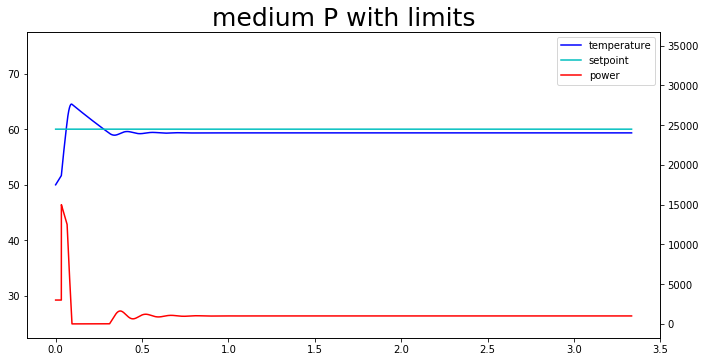

In [25]:
save_animation(proportional_limited(1500), left_columns, left_colors, right_columns, right_colors, 
               'medium P with limits', left_range, right_range, 'upper right')

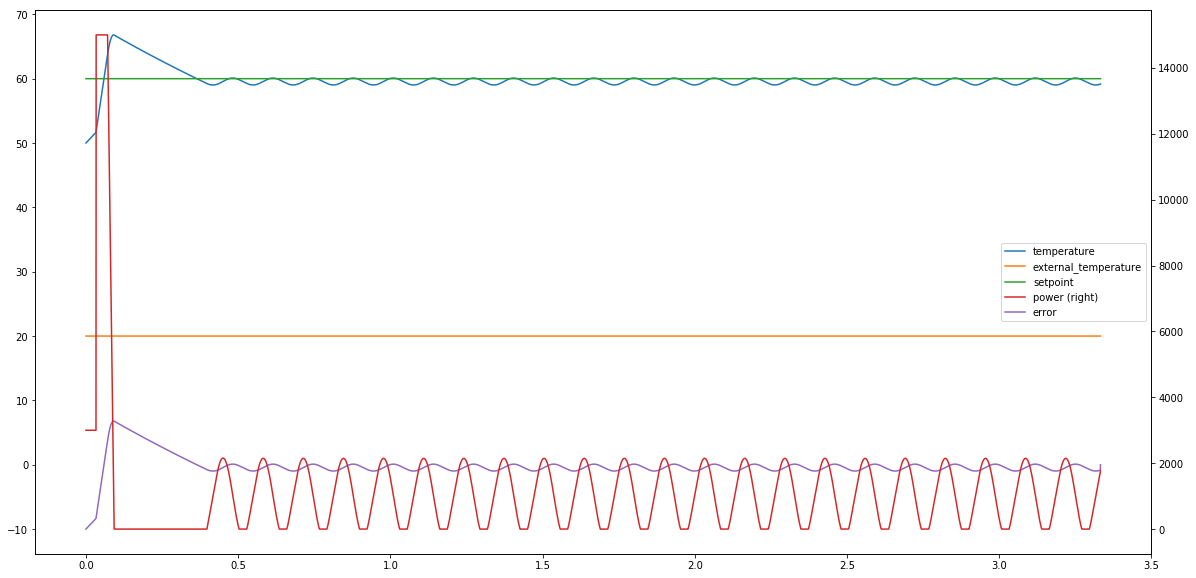

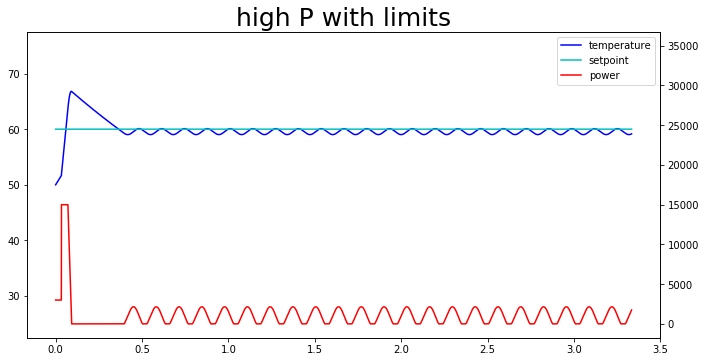

In [26]:
save_animation(proportional_limited(2200), left_columns, left_colors, right_columns, right_colors, 
               'high P with limits', left_range, right_range, 'upper right')

### proportional integral

In [27]:
def pid(proportional, integral, max_time, clip_range, windup_reset, 
        derivative, derivative_process, derivative_enable, plot=True):
    time = np.arange(0, max_time, 1, dtype=np.float64)
    max_power = 15000
    power = np.full_like(time, 3000)
    external_temperature = np.full_like(time, 20)
    external_temperature[9000:] = -50
    temperature = np.full_like(time, np.nan)
    temperature[0] = 50
    setpoint = np.full_like(time, 60)
    setpoint[2500:] = 50
    setpoint[6000:] = 70
    delay = 120
    error = np.zeros_like(time)
    integral_error = np.zeros_like(time)
    derivative_error = np.zeros_like(time)

    for i in range(len(time) - 1):
        error[i] = temperature[i] - setpoint[i]
        time_diff = time[i + 1] - time[i]
        if i >= 1:
            integral_error[i] = integral_error[i-1] + error[i] * time_diff
            if derivative_process and derivative_enable:
                derivative_error[i] = (temperature[i] - temperature[i - 1]) / time_diff
            elif derivative_enable:
                derivative_error[i] = (error[i] - error[i - 1]) / time_diff
        next_power = - proportional * error[i] - integral * integral_error[i] - derivative * derivative_error[i]
        if next_power > max_power and clip_range:
            next_power = max_power
            if windup_reset:
                integral_error[i] = integral_error[i-1]
        elif next_power < 0 and clip_range:
            next_power = 0
            if windup_reset:
                integral_error[i] = integral_error[i-1]
        if i + delay < len(time):
            power[i + delay] = next_power
        temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                                  args=(power[i+1], external_temperature[i], heat_capacity, 
                                        heat_transfer_coefficient, surface),
                                 )[-1]

    data = pd.DataFrame(index=time / 3600, data={
                                'temperature':  temperature,
                                   'external_temperature': external_temperature,
                                   'setpoint': setpoint,
                                   'derivative_error': - derivative_error * derivative,
                                   'power': power,
                                   'integral_error': - integral_error * integral,
                                  'proportional_error': - error * proportional
                                  })
    if plot:
        data.plot(secondary_y=('power', 'proportional_error', 'derivative_error', 'integral_error'))
        plt.show()
    return data

display(interactive(pid,
                    max_time=widgets.IntSlider(min=3000, max=20000, step=100, value=12000),
                    clip_range=widgets.Checkbox(value=True),
                    windup_reset=widgets.Checkbox(value=True),
                    proportional=widgets.FloatSlider(min=0, max=5000, step=10, value=840),
                    integral=widgets.FloatSlider(min=0.0, max=20.0, value=0.8),
                    derivative=widgets.FloatSlider(min=0, max=100000.0, step=100, value=25000),
                    derivative_process=widgets.Checkbox(value=True),
                    derivative_enable=widgets.Checkbox(value=True),
                   ))

interactive(children=(FloatSlider(value=840.0, description='proportional', max=5000.0, step=10.0), FloatSlider…

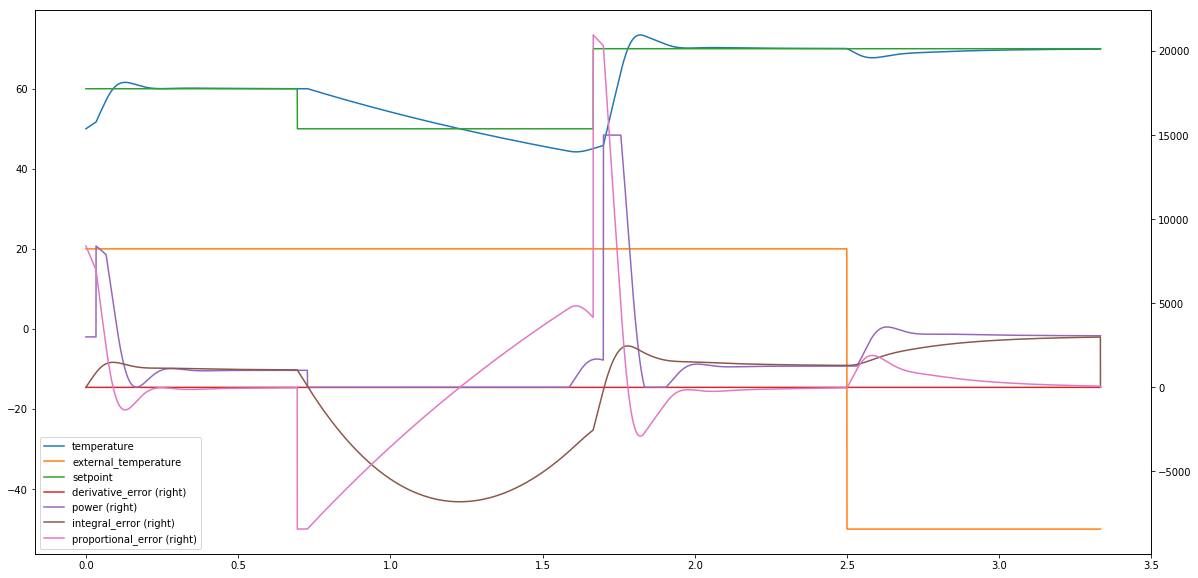

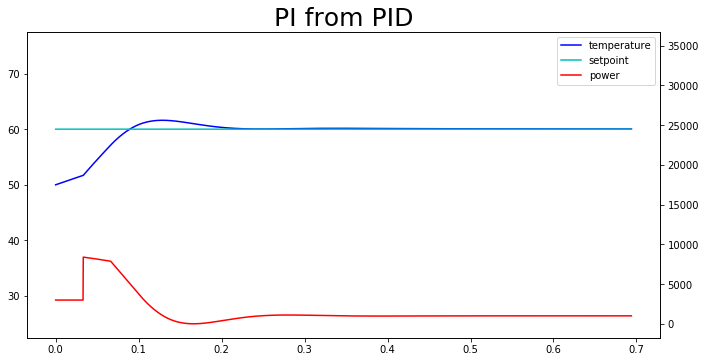

In [28]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=0, 
        clip_range=True, windup_reset=False, 
        derivative_enable = True, derivative_process=False,
        max_time = 12000
       ).iloc[:2500], 
    left_columns, left_colors, right_columns, right_colors, 
    'PI from PID', left_range, right_range, 'upper right')

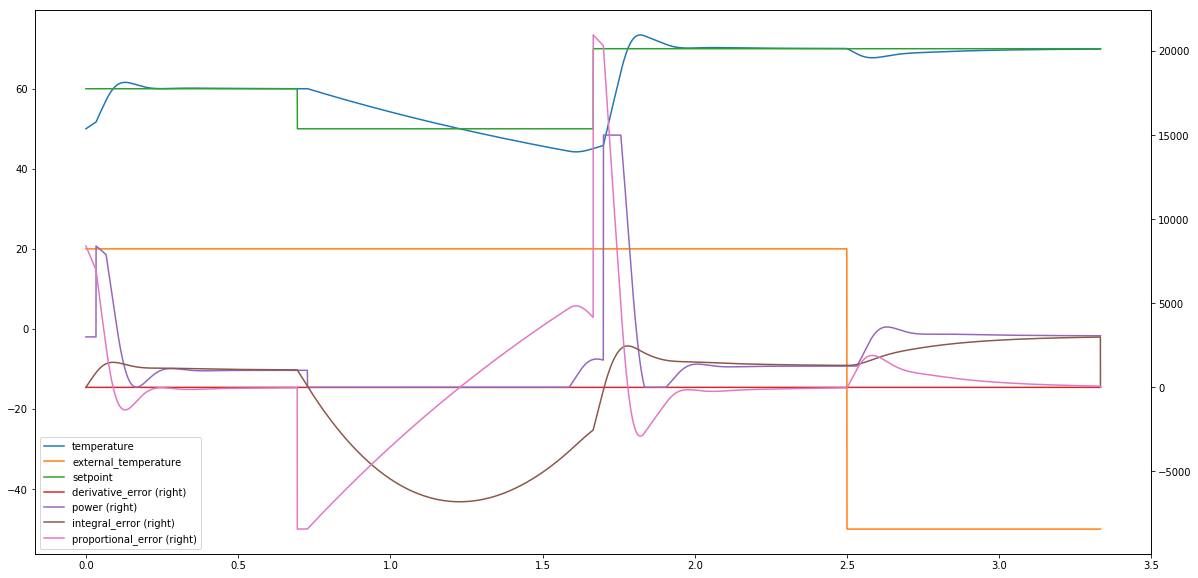

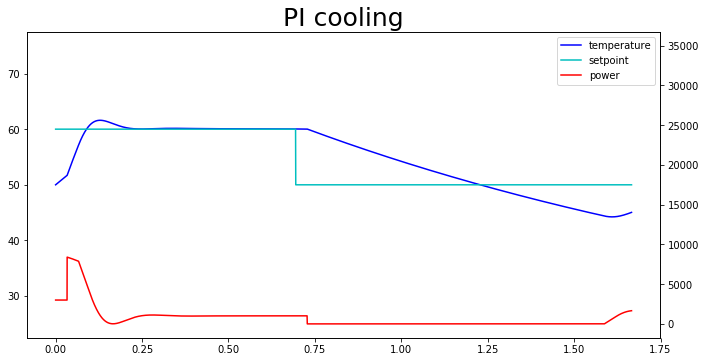

In [29]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=0, 
        clip_range=True, windup_reset=False, 
        derivative_enable = True, derivative_process=False,
        max_time = 12000
       ).iloc[:6000], 
    left_columns, left_colors, right_columns, right_colors, 
    'PI cooling', left_range, right_range, 'upper right')

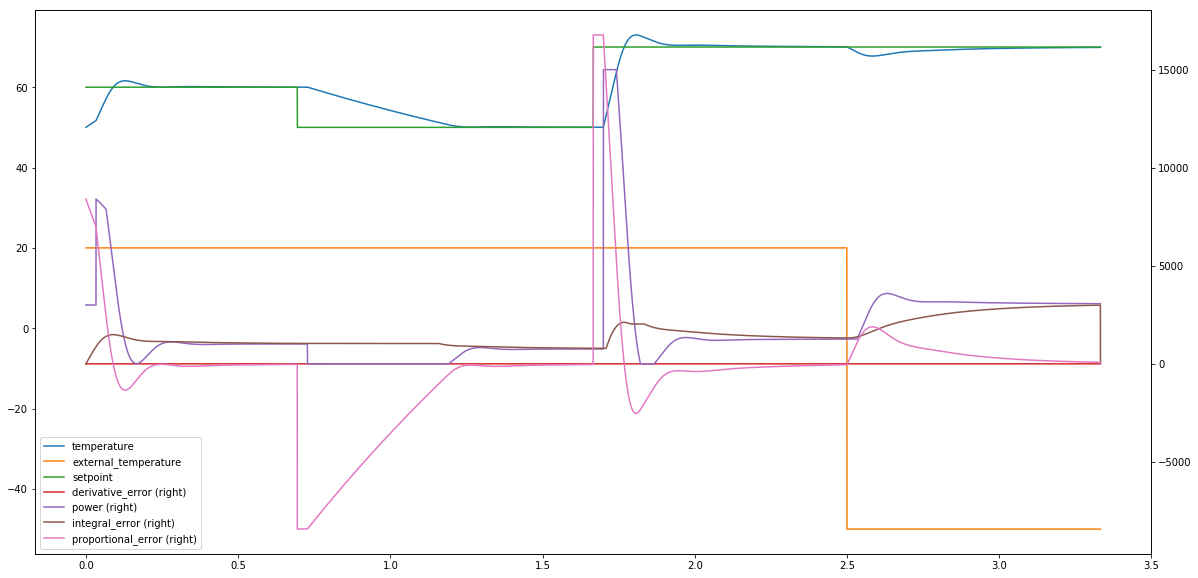

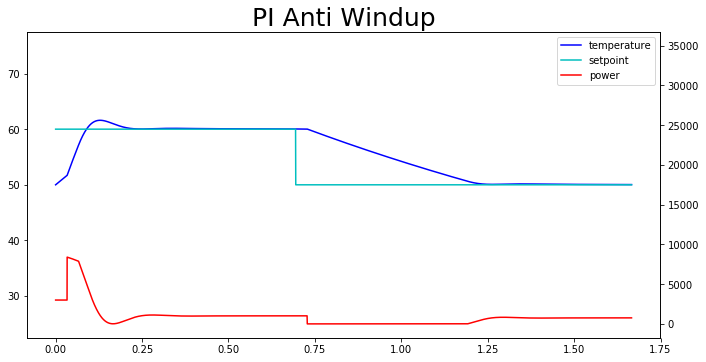

In [30]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=0, 
        clip_range=True, windup_reset=True, 
        derivative_enable = True, derivative_process=False,
        max_time = 12000
       ).iloc[:6000], 
    left_columns, left_colors, right_columns, right_colors, 
    'PI Anti Windup', left_range, right_range, 'upper right')

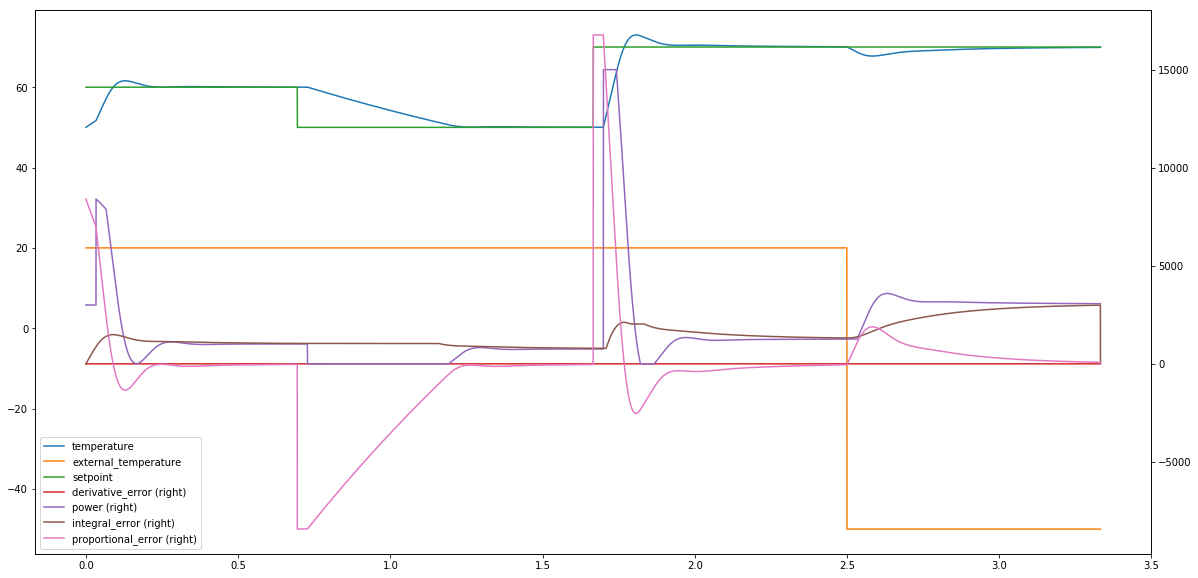

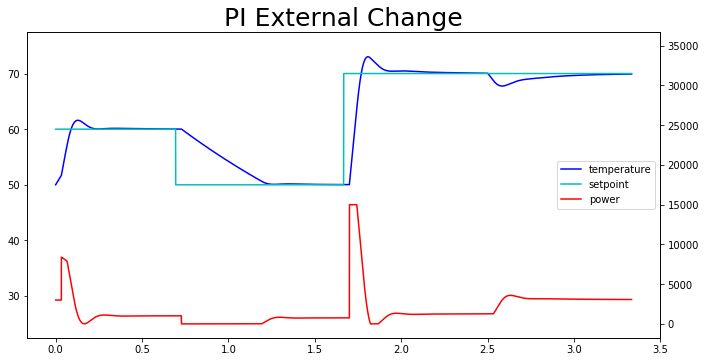

In [31]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=0, 
        clip_range=True, windup_reset=True, 
        derivative_enable = True, derivative_process=False,
        max_time = 12000
       ), 
    left_columns, left_colors, right_columns, right_colors, 
    'PI External Change', left_range, right_range, 'center right')

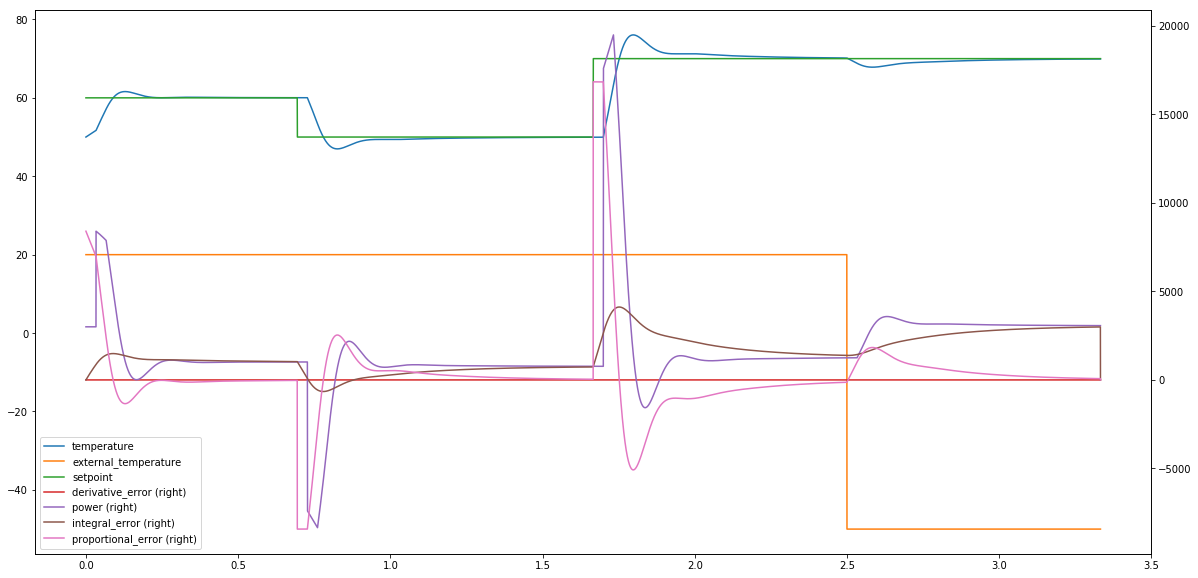

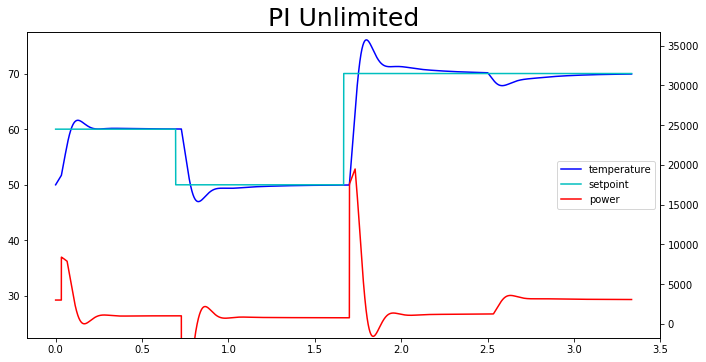

In [32]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=0, 
        clip_range=False, windup_reset=True, 
        derivative_enable = True, derivative_process=False,
        max_time = 12000
       ), 
    left_columns, left_colors, right_columns, right_colors, 
    'PI Unlimited',left_range, right_range, 'center right')

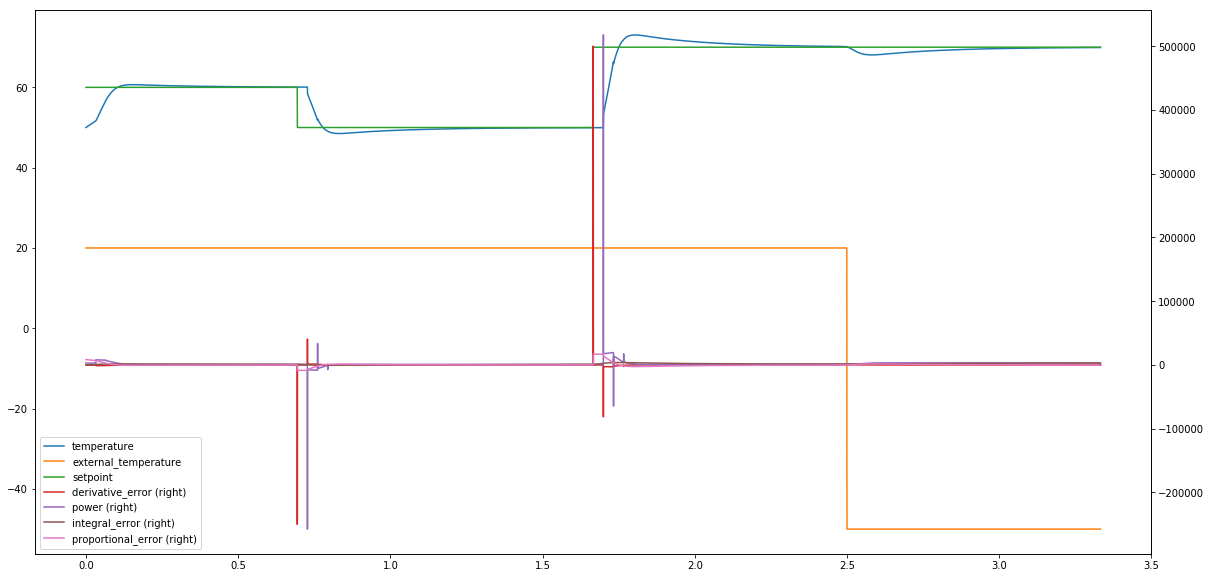

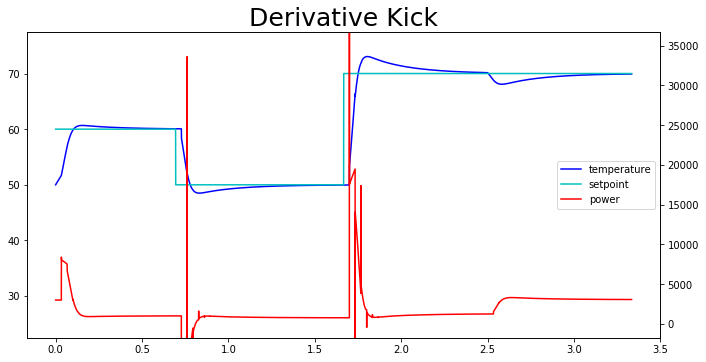

In [33]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=25000, 
        clip_range=False, windup_reset=True, 
        derivative_enable = True, derivative_process=False,
        max_time = 12000
       ), 
    left_columns, left_colors, right_columns, right_colors, 
    'Derivative Kick', left_range, right_range, 'center right')

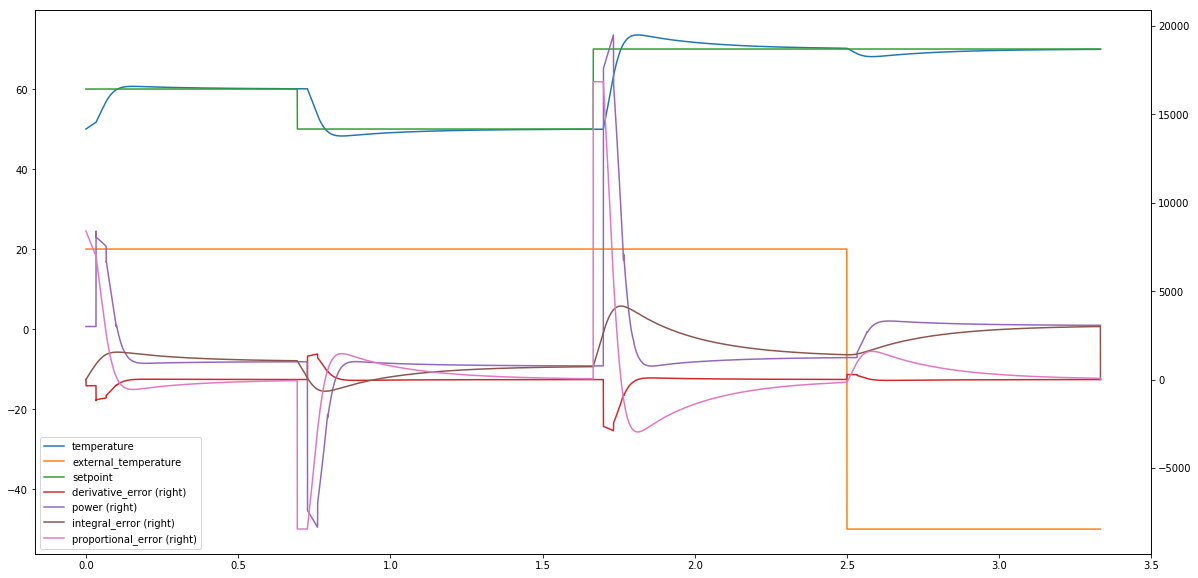

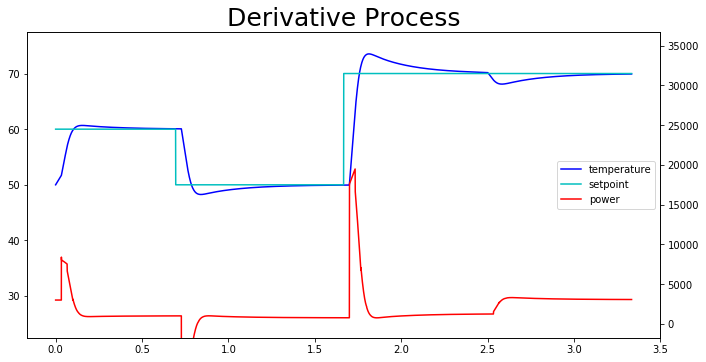

In [34]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=25000, 
        clip_range=False, windup_reset=True, 
        derivative_enable = True, derivative_process=True,
        max_time = 12000
       ), 
    left_columns, left_colors, right_columns, right_colors, 
    'Derivative Process', left_range, right_range, 'center right')

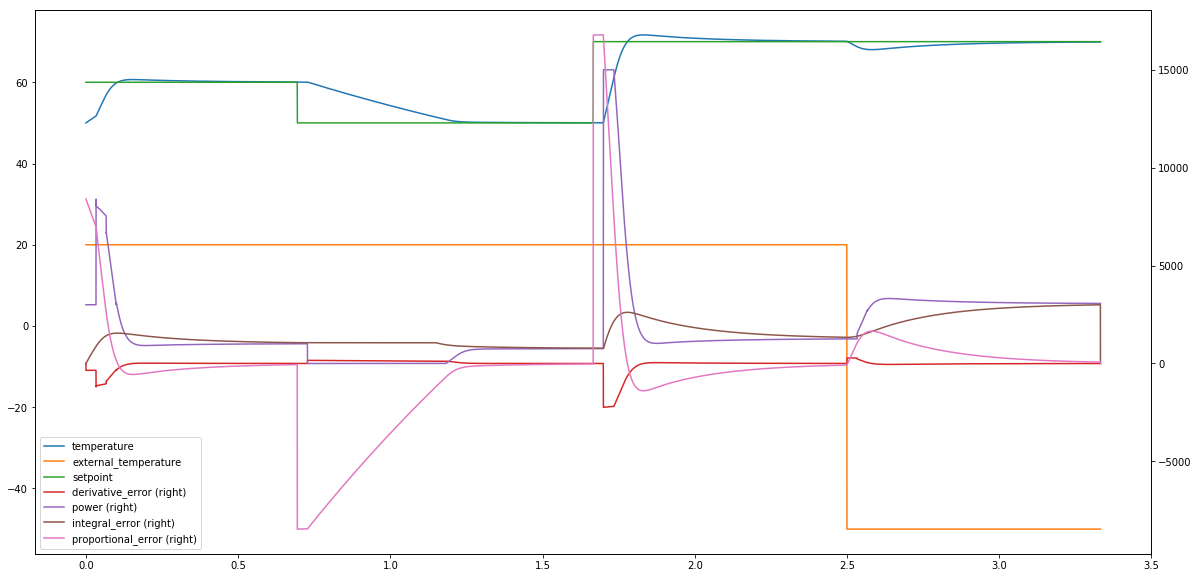

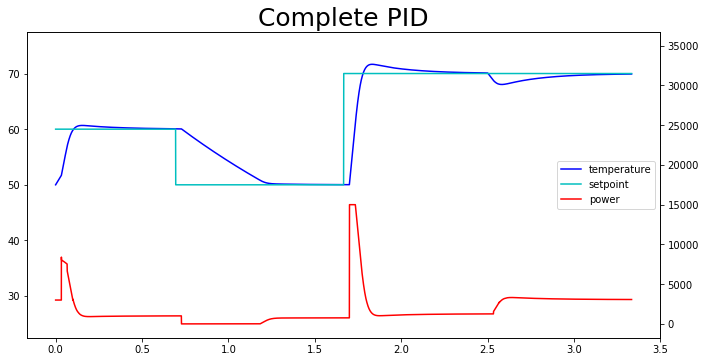

In [35]:
save_animation(
    pid(proportional = 840, integral=0.8, derivative=25000, 
        clip_range=True, windup_reset=True, 
        derivative_enable = True, derivative_process=True,
        max_time = 12000
       ), 
    left_columns, left_colors, right_columns, right_colors, 
    'Complete PID', left_range, right_range, 'center right')

### Ziegler–Nichols method

In [36]:
Ku = 2120
Tu = 3500 / 7
Tu

500.0

In [37]:
(0.5 * Ku)

1060.0

In [38]:
(0.45 * Ku, 0.54 * Ku / Tu)

(954.0, 2.2896000000000005)

In [39]:
(0.6 * Ku, 1.2 * Ku / Tu, 0.6 * Ku * Tu / 8)

(1272.0, 5.088, 79500.0)

no overshoot

In [40]:
(0.2 * Ku, 0.2 * Ku * 2 / Tu, 0.2 * Ku * Tu / 3)

(424.0, 1.696, 70666.66666666667)

### Tuning animation

In [41]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c']
right_columns = ['power']
right_colors = ['r']
index_range = [0, 12000 / 3600]
left_range = [25, 75]
right_range = [0, 35000]

In [42]:
length = 250 + 250 + 250 + 125
parameter_space = pd.DataFrame({
    'proportional': np.full(length, 0), 
    'integral': np.full(length, 0), 
    'max_time': np.full(length, 12000), 
    'clip_range': np.full(length, True), 
    'windup_reset': np.full(length, True), 
    'derivative': np.full(length, 0), 
    'derivative_process': np.full(length, True), 
    'derivative_enable': np.full(length, True), 
    'plot': np.full(length, False)})

In [43]:
parameter_space.loc[:124, 'proportional'] = np.linspace(0, 3000, 125, dtype=np.float)
parameter_space.loc[125:249, 'proportional']= np.linspace(3000, 840, 125, dtype=np.float)
parameter_space.loc[250:, 'proportional'] = 840
parameter_space.loc[250:374, 'integral'] = np.linspace(0, 7, 125, dtype=np.float)
parameter_space.loc[375:499, 'integral'] = np.linspace(7, 0.8, 125, dtype=np.float)
parameter_space.loc[500:, 'integral'] = 0.8
parameter_space.loc[500:624, 'derivative'] = np.linspace(0, 200000, 125, dtype=np.float)
parameter_space.loc[625:749, 'derivative'] = np.linspace(200000, 25000, 125, dtype=np.float)
parameter_space.loc[750:, 'derivative'] = 25000

In [ ]:
parameter_animation(parameter_space, left_columns, left_colors, right_columns, right_colors, 
                        'PID Tuning', index_range, left_range, right_range, legend_loc='center right')